In [1]:
import torch  # Importing the PyTorch library
import torch.nn as nn  # Importing the neural network module from PyTorch
import torch.optim as optim  # Importing the optimization module from PyTorch
import random  # Importing the random module for random number generation
from collections import deque  # Importing deque for efficiently managing the experience replay buffer
import numpy as np  # Importing NumPy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs
import graphviz  # Plotting the architecture of Neural Network

In [2]:
# Check if GPU is available and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available, else CPU

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    """ A simple grid world environment """
    def __init__(self, size=4):
        self.size = size  # Set the size of the grid
        self.reset()  # Reset the environment to its initial state

    def reset(self):
        """ Reset the environment and return the initial state """
        self.state = (0, 0)  # Set the initial state to the top-left corner of the grid
        return np.array(self.state)  # Return the initial state as a NumPy array

    def step(self, action):
        """ Take an action and return the new state, reward, and done status """
        x, y = self.state  # Unpack the current state into x and y coordinates
        if action == 0:  # If action is 'Up'
            x = max(0, x - 1)  # Move up but not beyond the grid
        elif action == 1:  # If action is 'Down'
            x = min(self.size - 1, x + 1)  # Move down but not beyond the grid
        elif action == 2:  # If action is 'Left'
            y = max(0, y - 1)  # Move left but not beyond the grid
        elif action == 3:  # If action is 'Right'
            y = min(self.size - 1, y + 1)  # Move right but not beyond the grid

        self.state = (x, y)  # Update the current state
        reward = -1 if (x, y) != (self.size - 1, self.size - 1) else 0  # Set reward
        done = (x, y) == (self.size - 1, self.size - 1)  # Check if the goal state is reached
        return np.array(self.state), reward, done  # Return the new state, reward, and done status

    def render(self):
        """ Render the grid world """
        grid = np.zeros((self.size, self.size))
        grid[self.state] = 1  # Mark the agent's position
        plt.imshow(grid, cmap='Greys', origin='upper')
        plt.xticks(range(self.size))
        plt.yticks(range(self.size))
        plt.grid(True)
        plt.show()

In [4]:
class DQN(nn.Module):
    """ Deep Q-Network """
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()  # Call the parent class constructor
        self.fc1 = nn.Linear(input_dim, 24)  # First fully connected layer with input_dim to 24 neurons
        self.fc2 = nn.Linear(24, 24)  # Second fully connected layer with 24 to 24 neurons
        self.fc3 = nn.Linear(24, output_dim)  # Output layer with 24 neurons to output_dim neurons

    def forward(self, x):
        """ Forward pass through the network """
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        return self.fc3(x)  # Return the output of the final layer

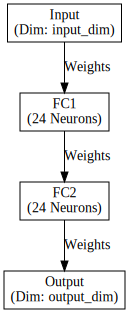

In [5]:
from graphviz import Digraph

def visualize_dqn():
    dot = Digraph()

    # Input Layer
    dot.node('Input', 'Input\n(Dim: input_dim)', shape='rect')

    # Hidden Layers
    dot.node('FC1', 'FC1\n(24 Neurons)', shape='rect')
    dot.node('FC2', 'FC2\n(24 Neurons)', shape='rect')

    # Output Layer
    dot.node('Output', 'Output\n(Dim: output_dim)', shape='rect')

    # Edges
    dot.edge('Input', 'FC1', label='Weights')
    dot.edge('FC1', 'FC2', label='Weights')
    dot.edge('FC2', 'Output', label='Weights')

    # Render and display the graph
    return dot

# Visualize the DQN
dqn_graph = visualize_dqn()
dqn_graph.render('dqn_architecture', format='png', cleanup=True)  # Save and render the image
dqn_graph  # Display the graph in the notebook

In [6]:
def plot_rewards(rewards):
    """ Function to plot the total rewards per episode """
    plt.plot(rewards)  # Plot the rewards over episodes
    plt.xlabel('Episode')  # Label for the x-axis
    plt.ylabel('Total Reward')  # Label for the y-axis
    plt.title('Total Rewards per Episode')  # Title of the plot
    plt.grid()  # Add grid to the plot
    plt.show()  # Display the plot

In [7]:
def train_model():
    # Hyperparameters
    episodes = 1000  # Number of training episodes
    gamma = 0.99  # Discount factor for future rewards
    epsilon = 1.0  # Initial exploration rate
    epsilon_decay = 0.995  # Decay rate for exploration
    min_epsilon = 0.01  # Minimum exploration rate
    batch_size = 32  # Batch size for experience replay
    memory = deque(maxlen=10000)  # Experience replay buffer
    env = GridWorld()  # Create an instance of the GridWorld environment
    model = DQN(2, 4).to(device)  # Move model to the appropriate device
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for the model
    loss_fn = nn.MSELoss()  # Mean Squared Error loss function

    rewards_per_episode = []  # List to store total rewards per episode

    for episode in range(episodes):
        state = env.reset()  # Reset the environment for a new episode
        state = torch.tensor(state, dtype=torch.float32).to(device)  # Convert state to a tensor and move to device
        total_reward = 0  # Initialize total reward for the episode
        done = False  # Initialize done status

        while not done:  # Loop until the episode is done
            if random.random() < epsilon:  # Check if we should explore
                action = random.randint(0, 3)  # Choose a random action
            else:
                with torch.no_grad():  # Disable gradient calculation for inference
                    q_values = model(state.unsqueeze(0))  # Get Q-values from the model
                    action = torch.argmax(q_values).item()  # Choose the action with the highest Q-value

            next_state, reward, done = env.step(action)  # Take the action in the environment
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)  # Convert next state to tensor
            total_reward += reward  # Update total reward

            memory.append((state, action, reward, next_state, done))  # Store experience in memory
            state = next_state  # Update current state

            if len(memory) >= batch_size:  # Check if we have enough experiences to sample
                batch = random.sample(memory, batch_size)  # Sample a batch from memory
                states, actions, rewards, next_states, dones = zip(*batch)  # Unzip the batch into separate variables
                states = torch.stack(states).to(device)  # Convert states to tensor
                next_states = torch.stack(next_states).to(device)  # Convert next states to tensor
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)  # Convert rewards to tensor
                actions = torch.tensor(actions).to(device)  # Convert actions to tensor
                dones = torch.tensor(dones, dtype=torch.float32).to(device)  # Convert dones to tensor

                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-values for the actions taken
                next_q_values = model(next_states).max(1)[0]  # Get max Q-values for the next states
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)  # Calculate expected Q-values

                loss = loss_fn(q_values, expected_q_values.detach())  # Calculate loss
                optimizer.zero_grad()  # Clear previous gradients
                loss.backward()  # Backpropagate to compute gradients
                optimizer.step()  # Update model parameters

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon for exploration
        rewards_per_episode.append(total_reward)  # Store the total reward for this episode
        print(f'Episode {episode}, Total Reward: {total_reward}')  # Print the episode number and total reward

    plot_rewards(rewards_per_episode)  # Plot the rewards after training

Episode 0, Total Reward: -8
Episode 1, Total Reward: -48
Episode 2, Total Reward: -25
Episode 3, Total Reward: -116
Episode 4, Total Reward: -44
Episode 5, Total Reward: -183
Episode 6, Total Reward: -201
Episode 7, Total Reward: -29
Episode 8, Total Reward: -13
Episode 9, Total Reward: -15
Episode 10, Total Reward: -7
Episode 11, Total Reward: -56
Episode 12, Total Reward: -7
Episode 13, Total Reward: -7
Episode 14, Total Reward: -50
Episode 15, Total Reward: -6
Episode 16, Total Reward: -69
Episode 17, Total Reward: -46
Episode 18, Total Reward: -40
Episode 19, Total Reward: -38
Episode 20, Total Reward: -7
Episode 21, Total Reward: -26
Episode 22, Total Reward: -16
Episode 23, Total Reward: -7
Episode 24, Total Reward: -30
Episode 25, Total Reward: -17
Episode 26, Total Reward: -32
Episode 27, Total Reward: -16
Episode 28, Total Reward: -72
Episode 29, Total Reward: -30
Episode 30, Total Reward: -14
Episode 31, Total Reward: -62
Episode 32, Total Reward: -13
Episode 33, Total Reward

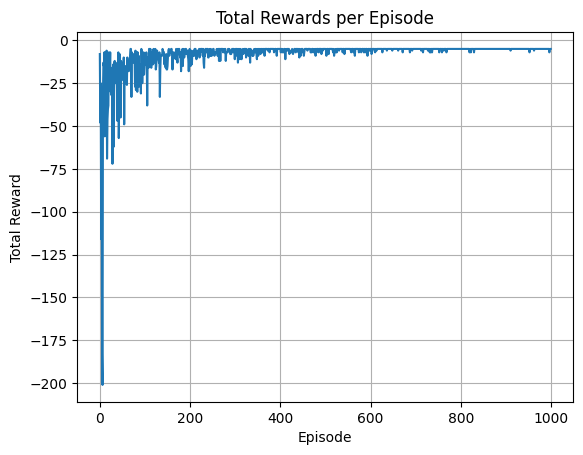

In [8]:
# Directly call the function to start training
train_model()

In [9]:
########## Advanced DQN ##################################

In [10]:
import torch  # Importing the PyTorch library
import torch.nn as nn  # Importing the neural network module from PyTorch
import torch.optim as optim  # Importing the optimization module from PyTorch
import random  # Importing the random module for random number generation
from collections import deque  # Importing deque for efficiently managing the experience replay buffer
import numpy as np  # Importing NumPy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs

In [11]:
# Check if GPU is available and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available, else CPU

In [12]:
class GridWorld:
    """ A simple grid world environment """
    def __init__(self, size=4):
        self.size = size  # Set the size of the grid
        self.reset()  # Reset the environment to its initial state

    def reset(self):
        """ Reset the environment and return the initial state """
        self.state = (0, 0)  # Set the initial state to the top-left corner of the grid
        return np.array(self.state)  # Return the initial state as a NumPy array

    def step(self, action):
        """ Take an action and return the new state, reward, and done status """
        x, y = self.state  # Unpack the current state into x and y coordinates
        if action == 0:  # If action is 'Up'
            x = max(0, x - 1)  # Move up but not beyond the grid
        elif action == 1:  # If action is 'Down'
            x = min(self.size - 1, x + 1)  # Move down but not beyond the grid
        elif action == 2:  # If action is 'Left'
            y = max(0, y - 1)  # Move left but not beyond the grid
        elif action == 3:  # If action is 'Right'
            y = min(self.size - 1, y + 1)  # Move right but not beyond the grid

        self.state = (x, y)  # Update the current state
        reward = -1 if (x, y) != (self.size - 1, self.size - 1) else 0  # Set reward
        done = (x, y) == (self.size - 1, self.size - 1)  # Check if the goal state is reached
        return np.array(self.state), reward, done  # Return the new state, reward, and done status

    def render(self):
        """ Render the grid world """
        grid = np.zeros((self.size, self.size))
        grid[self.state] = 1  # Mark the agent's position
        plt.imshow(grid, cmap='Greys', origin='upper')
        plt.xticks(range(self.size))
        plt.yticks(range(self.size))
        plt.grid(True)
        plt.show()


In [13]:
class DQN(nn.Module):
    """ Deep Q-Network """
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()  # Call the parent class constructor
        self.fc1 = nn.Linear(input_dim, 24)  # First fully connected layer with input_dim to 24 neurons
        self.fc2 = nn.Linear(24, 24)  # Second fully connected layer with 24 to 24 neurons
        self.fc3 = nn.Linear(24, output_dim)  # Output layer with 24 neurons to output_dim neurons

    def forward(self, x):
        """ Forward pass through the network """
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        return self.fc3(x)  # Return the output of the final layer

In [14]:
def plot_rewards(rewards):
    """ Function to plot the total rewards per episode """
    plt.plot(rewards)  # Plot the rewards over episodes
    plt.xlabel('Episode')  # Label for the x-axis
    plt.ylabel('Total Reward')  # Label for the y-axis
    plt.title('Total Rewards per Episode')  # Title of the plot
    plt.grid()  # Add grid to the plot
    plt.show()  # Display the plot

In [15]:
def train_model():
    # Hyperparameters
    episodes = 1000  # Number of training episodes
    gamma = 0.99  # Discount factor for future rewards
    epsilon = 1.0  # Initial exploration rate
    epsilon_decay = 0.995  # Decay rate for exploration
    min_epsilon = 0.01  # Minimum exploration rate
    batch_size = 32  # Batch size for experience replay
    memory = deque(maxlen=10000)  # Experience replay buffer
    env = GridWorld()  # Create an instance of the GridWorld environment
    model = DQN(2, 4).to(device)  # Move model to the appropriate device
    target_model = DQN(2, 4).to(device)  # Create the target model
    target_model.load_state_dict(model.state_dict())  # Initialize target model with the same weights
    target_model.eval()  # Set target model to evaluation mode
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for the model
    loss_fn = nn.MSELoss()  # Mean Squared Error loss function

    rewards_per_episode = []  # List to store total rewards per episode

    for episode in range(episodes):
        state = env.reset()  # Reset the environment for a new episode
        state = torch.tensor(state, dtype=torch.float32).to(device)  # Convert state to a tensor and move to device
        total_reward = 0  # Initialize total reward for the episode
        done = False  # Initialize done status

        while not done:  # Loop until the episode is done
            if random.random() < epsilon:  # Check if we should explore
                action = random.randint(0, 3)  # Choose a random action
            else:
                with torch.no_grad():  # Disable gradient calculation for inference
                    q_values = model(state.unsqueeze(0))  # Get Q-values from the model
                    action = torch.argmax(q_values).item()  # Choose the action with the highest Q-value

            next_state, reward, done = env.step(action)  # Take the action in the environment
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)  # Convert next state to tensor
            total_reward += reward  # Update total reward

            memory.append((state, action, reward, next_state, done))  # Store experience in memory
            state = next_state  # Update current state

            if len(memory) >= batch_size:  # Check if we have enough experiences to sample
                batch = random.sample(memory, batch_size)  # Sample a batch from memory
                states, actions, rewards, next_states, dones = zip(*batch)  # Unzip the batch into separate variables
                states = torch.stack(states).to(device)  # Convert states to tensor
                next_states = torch.stack(next_states).to(device)  # Convert next states to tensor
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)  # Convert rewards to tensor
                actions = torch.tensor(actions).to(device)  # Convert actions to tensor
                dones = torch.tensor(dones, dtype=torch.float32).to(device)  # Convert dones to tensor

                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-values for the actions taken
                next_q_values = target_model(next_states).max(1)[0]  # Get max Q-values for the next states from the target model
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)  # Calculate expected Q-values

                loss = loss_fn(q_values, expected_q_values.detach())  # Calculate loss
                optimizer.zero_grad()  # Clear previous gradients
                loss.backward()  # Backpropagate to compute gradients
                optimizer.step()  # Update model parameters

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon for exploration
        rewards_per_episode.append(total_reward)  # Store the total reward for this episode

        # Update the target network every 10 episodes
        if episode % 10 == 0:
            target_model.load_state_dict(model.state_dict())  # Copy weights from the model to the target model

        print(f'Episode {episode}, Total Reward: {total_reward}')  # Print the episode number and total reward

    plot_rewards(rewards_per_episode)  # Plot the rewards after training

Episode 0, Total Reward: -74
Episode 1, Total Reward: -64
Episode 2, Total Reward: -70
Episode 3, Total Reward: -26
Episode 4, Total Reward: -10
Episode 5, Total Reward: -117
Episode 6, Total Reward: -81
Episode 7, Total Reward: -31
Episode 8, Total Reward: -53
Episode 9, Total Reward: -149
Episode 10, Total Reward: -28
Episode 11, Total Reward: -24
Episode 12, Total Reward: -28
Episode 13, Total Reward: -30
Episode 14, Total Reward: -7
Episode 15, Total Reward: -22
Episode 16, Total Reward: -27
Episode 17, Total Reward: -8
Episode 18, Total Reward: -18
Episode 19, Total Reward: -18
Episode 20, Total Reward: -98
Episode 21, Total Reward: -7
Episode 22, Total Reward: -17
Episode 23, Total Reward: -17
Episode 24, Total Reward: -12
Episode 25, Total Reward: -22
Episode 26, Total Reward: -13
Episode 27, Total Reward: -11
Episode 28, Total Reward: -30
Episode 29, Total Reward: -5
Episode 30, Total Reward: -23
Episode 31, Total Reward: -17
Episode 32, Total Reward: -5
Episode 33, Total Rewar

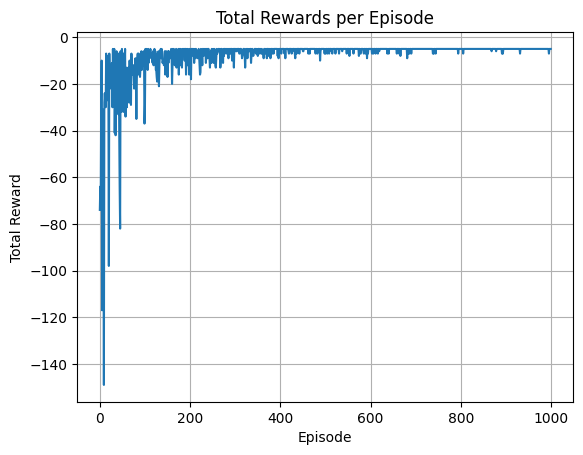

In [16]:
# Directly call the function to start training
train_model()

In [17]:
## In the upcoming two cells, you can see unified code (instead of running the code part by part)

Episode 0, Total Reward: -63
Episode 1, Total Reward: -25
Episode 2, Total Reward: -6
Episode 3, Total Reward: -71
Episode 4, Total Reward: -75
Episode 5, Total Reward: -18
Episode 6, Total Reward: -20
Episode 7, Total Reward: -41
Episode 8, Total Reward: -48
Episode 9, Total Reward: -42
Episode 10, Total Reward: -118
Episode 11, Total Reward: -19
Episode 12, Total Reward: -7
Episode 13, Total Reward: -7
Episode 14, Total Reward: -64
Episode 15, Total Reward: -19
Episode 16, Total Reward: -14
Episode 17, Total Reward: -80
Episode 18, Total Reward: -16
Episode 19, Total Reward: -21
Episode 20, Total Reward: -50
Episode 21, Total Reward: -23
Episode 22, Total Reward: -30
Episode 23, Total Reward: -11
Episode 24, Total Reward: -42
Episode 25, Total Reward: -46
Episode 26, Total Reward: -120
Episode 27, Total Reward: -7
Episode 28, Total Reward: -31
Episode 29, Total Reward: -64
Episode 30, Total Reward: -31
Episode 31, Total Reward: -8
Episode 32, Total Reward: -7
Episode 33, Total Reward

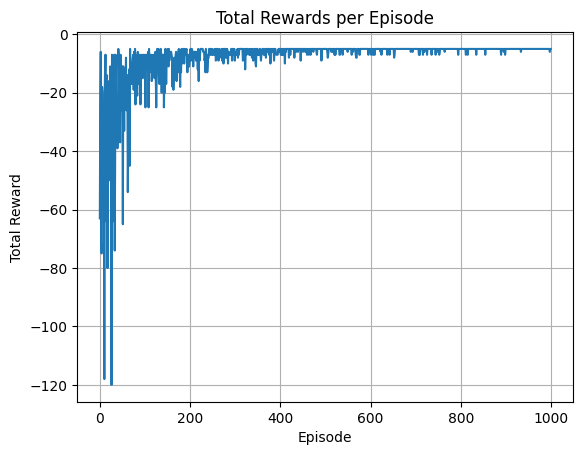

In [18]:
## Simple DQN with Experince Replay (I did not use target network for this implementation)
import torch  # Importing the PyTorch library
import torch.nn as nn  # Importing the neural network module from PyTorch
import torch.optim as optim  # Importing the optimization module from PyTorch
import random  # Importing the random module for random number generation
from collections import deque  # Importing deque for efficiently managing the experience replay buffer
import numpy as np  # Importing NumPy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs
import graphviz  # Plotting the architecture of Neural Network

# Check if GPU is available and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available, else CPU


import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    """ A simple grid world environment """
    def __init__(self, size=4):
        self.size = size  # Set the size of the grid
        self.reset()  # Reset the environment to its initial state

    def reset(self):
        """ Reset the environment and return the initial state """
        self.state = (0, 0)  # Set the initial state to the top-left corner of the grid
        return np.array(self.state)  # Return the initial state as a NumPy array

    def step(self, action):
        """ Take an action and return the new state, reward, and done status """
        x, y = self.state  # Unpack the current state into x and y coordinates
        if action == 0:  # If action is 'Up'
            x = max(0, x - 1)  # Move up but not beyond the grid
        elif action == 1:  # If action is 'Down'
            x = min(self.size - 1, x + 1)  # Move down but not beyond the grid
        elif action == 2:  # If action is 'Left'
            y = max(0, y - 1)  # Move left but not beyond the grid
        elif action == 3:  # If action is 'Right'
            y = min(self.size - 1, y + 1)  # Move right but not beyond the grid

        self.state = (x, y)  # Update the current state
        reward = -1 if (x, y) != (self.size - 1, self.size - 1) else 0  # Set reward
        done = (x, y) == (self.size - 1, self.size - 1)  # Check if the goal state is reached
        return np.array(self.state), reward, done  # Return the new state, reward, and done status

    def render(self):
        """ Render the grid world """
        grid = np.zeros((self.size, self.size))
        grid[self.state] = 1  # Mark the agent's position
        plt.imshow(grid, cmap='Greys', origin='upper')
        plt.xticks(range(self.size))
        plt.yticks(range(self.size))
        plt.grid(True)
        plt.show()



class DQN(nn.Module):
    """ Deep Q-Network """
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()  # Call the parent class constructor
        self.fc1 = nn.Linear(input_dim, 24)  # First fully connected layer with input_dim to 24 neurons
        self.fc2 = nn.Linear(24, 24)  # Second fully connected layer with 24 to 24 neurons
        self.fc3 = nn.Linear(24, output_dim)  # Output layer with 24 neurons to output_dim neurons

    def forward(self, x):
        """ Forward pass through the network """
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        return self.fc3(x)  # Return the output of the final layer


def plot_rewards(rewards):
    """ Function to plot the total rewards per episode """
    plt.plot(rewards)  # Plot the rewards over episodes
    plt.xlabel('Episode')  # Label for the x-axis
    plt.ylabel('Total Reward')  # Label for the y-axis
    plt.title('Total Rewards per Episode')  # Title of the plot
    plt.grid()  # Add grid to the plot
    plt.show()  # Display the plot



def train_model():
    # Hyperparameters
    episodes = 1000  # Number of training episodes
    gamma = 0.99  # Discount factor for future rewards
    epsilon = 1.0  # Initial exploration rate
    epsilon_decay = 0.995  # Decay rate for exploration
    min_epsilon = 0.01  # Minimum exploration rate
    batch_size = 32  # Batch size for experience replay
    memory = deque(maxlen=10000)  # Experience replay buffer
    env = GridWorld()  # Create an instance of the GridWorld environment
    model = DQN(2, 4).to(device)  # Move model to the appropriate device
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for the model
    loss_fn = nn.MSELoss()  # Mean Squared Error loss function

    rewards_per_episode = []  # List to store total rewards per episode

    for episode in range(episodes):
        state = env.reset()  # Reset the environment for a new episode
        state = torch.tensor(state, dtype=torch.float32).to(device)  # Convert state to a tensor and move to device
        total_reward = 0  # Initialize total reward for the episode
        done = False  # Initialize done status

        while not done:  # Loop until the episode is done
            if random.random() < epsilon:  # Check if we should explore
                action = random.randint(0, 3)  # Choose a random action
            else:
                with torch.no_grad():  # Disable gradient calculation for inference
                    q_values = model(state.unsqueeze(0))  # Get Q-values from the model
                    action = torch.argmax(q_values).item()  # Choose the action with the highest Q-value

            next_state, reward, done = env.step(action)  # Take the action in the environment
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)  # Convert next state to tensor
            total_reward += reward  # Update total reward

            memory.append((state, action, reward, next_state, done))  # Store experience in memory
            state = next_state  # Update current state

            if len(memory) >= batch_size:  # Check if we have enough experiences to sample
                batch = random.sample(memory, batch_size)  # Sample a batch from memory
                states, actions, rewards, next_states, dones = zip(*batch)  # Unzip the batch into separate variables
                states = torch.stack(states).to(device)  # Convert states to tensor
                next_states = torch.stack(next_states).to(device)  # Convert next states to tensor
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)  # Convert rewards to tensor
                actions = torch.tensor(actions).to(device)  # Convert actions to tensor
                dones = torch.tensor(dones, dtype=torch.float32).to(device)  # Convert dones to tensor

                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-values for the actions taken
                next_q_values = model(next_states).max(1)[0]  # Get max Q-values for the next states
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)  # Calculate expected Q-values

                loss = loss_fn(q_values, expected_q_values.detach())  # Calculate loss
                optimizer.zero_grad()  # Clear previous gradients
                loss.backward()  # Backpropagate to compute gradients
                optimizer.step()  # Update model parameters

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon for exploration
        rewards_per_episode.append(total_reward)  # Store the total reward for this episode
        print(f'Episode {episode}, Total Reward: {total_reward}')  # Print the episode number and total reward

    plot_rewards(rewards_per_episode)  # Plot the rewards after training



# Directly call the function to start training
train_model()

Episode 0, Total Reward: -20
Episode 1, Total Reward: -18
Episode 2, Total Reward: -70
Episode 3, Total Reward: -20
Episode 4, Total Reward: -32
Episode 5, Total Reward: -187
Episode 6, Total Reward: -21
Episode 7, Total Reward: -14
Episode 8, Total Reward: -124
Episode 9, Total Reward: -22
Episode 10, Total Reward: -12
Episode 11, Total Reward: -62
Episode 12, Total Reward: -26
Episode 13, Total Reward: -32
Episode 14, Total Reward: -20
Episode 15, Total Reward: -38
Episode 16, Total Reward: -30
Episode 17, Total Reward: -14
Episode 18, Total Reward: -37
Episode 19, Total Reward: -13
Episode 20, Total Reward: -28
Episode 21, Total Reward: -31
Episode 22, Total Reward: -34
Episode 23, Total Reward: -77
Episode 24, Total Reward: -16
Episode 25, Total Reward: -49
Episode 26, Total Reward: -90
Episode 27, Total Reward: -20
Episode 28, Total Reward: -11
Episode 29, Total Reward: -21
Episode 30, Total Reward: -35
Episode 31, Total Reward: -21
Episode 32, Total Reward: -25
Episode 33, Total 

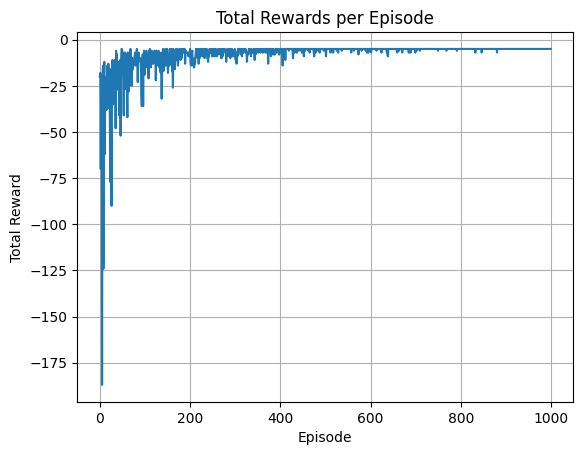

In [19]:
####### Advanced DQN with Target Network #########################
## Advanced DQN with Experince Replay (I included target network for this implementation)

import torch  # Importing the PyTorch library
import torch.nn as nn  # Importing the neural network module from PyTorch
import torch.optim as optim  # Importing the optimization module from PyTorch
import random  # Importing the random module for random number generation
from collections import deque  # Importing deque for efficiently managing the experience replay buffer
import numpy as np  # Importing NumPy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs

# Check if GPU is available and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available, else CPU

class GridWorld:
    """ A simple grid world environment """
    def __init__(self, size=4):
        self.size = size  # Set the size of the grid
        self.reset()  # Reset the environment to its initial state

    def reset(self):
        """ Reset the environment and return the initial state """
        self.state = (0, 0)  # Set the initial state to the top-left corner of the grid
        return np.array(self.state)  # Return the initial state as a NumPy array

    def step(self, action):
        """ Take an action and return the new state, reward, and done status """
        x, y = self.state  # Unpack the current state into x and y coordinates
        if action == 0:  # If action is 'Up'
            x = max(0, x - 1)  # Move up but not beyond the grid
        elif action == 1:  # If action is 'Down'
            x = min(self.size - 1, x + 1)  # Move down but not beyond the grid
        elif action == 2:  # If action is 'Left'
            y = max(0, y - 1)  # Move left but not beyond the grid
        elif action == 3:  # If action is 'Right'
            y = min(self.size - 1, y + 1)  # Move right but not beyond the grid

        self.state = (x, y)  # Update the current state
        reward = -1 if (x, y) != (self.size - 1, self.size - 1) else 0  # Set reward
        done = (x, y) == (self.size - 1, self.size - 1)  # Check if the goal state is reached
        return np.array(self.state), reward, done  # Return the new state, reward, and done status

    def render(self):
        """ Render the grid world """
        grid = np.zeros((self.size, self.size))
        grid[self.state] = 1  # Mark the agent's position
        plt.imshow(grid, cmap='Greys', origin='upper')
        plt.xticks(range(self.size))
        plt.yticks(range(self.size))
        plt.grid(True)
        plt.show()

class DQN(nn.Module):
    """ Deep Q-Network """
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()  # Call the parent class constructor
        self.fc1 = nn.Linear(input_dim, 24)  # First fully connected layer with input_dim to 24 neurons
        self.fc2 = nn.Linear(24, 24)  # Second fully connected layer with 24 to 24 neurons
        self.fc3 = nn.Linear(24, output_dim)  # Output layer with 24 neurons to output_dim neurons

    def forward(self, x):
        """ Forward pass through the network """
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        return self.fc3(x)  # Return the output of the final layer

def plot_rewards(rewards):
    """ Function to plot the total rewards per episode """
    plt.plot(rewards)  # Plot the rewards over episodes
    plt.xlabel('Episode')  # Label for the x-axis
    plt.ylabel('Total Reward')  # Label for the y-axis
    plt.title('Total Rewards per Episode')  # Title of the plot
    plt.grid()  # Add grid to the plot
    plt.show()  # Display the plot

def train_model():
    # Hyperparameters
    episodes = 1000  # Number of training episodes
    gamma = 0.99  # Discount factor for future rewards
    epsilon = 1.0  # Initial exploration rate
    epsilon_decay = 0.995  # Decay rate for exploration
    min_epsilon = 0.01  # Minimum exploration rate
    batch_size = 32  # Batch size for experience replay
    memory = deque(maxlen=10000)  # Experience replay buffer
    env = GridWorld()  # Create an instance of the GridWorld environment
    model = DQN(2, 4).to(device)  # Move model to the appropriate device
    target_model = DQN(2, 4).to(device)  # Create the target model
    target_model.load_state_dict(model.state_dict())  # Initialize target model with the same weights
    target_model.eval()  # Set target model to evaluation mode
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for the model
    loss_fn = nn.MSELoss()  # Mean Squared Error loss function

    rewards_per_episode = []  # List to store total rewards per episode

    for episode in range(episodes):
        state = env.reset()  # Reset the environment for a new episode
        state = torch.tensor(state, dtype=torch.float32).to(device)  # Convert state to a tensor and move to device
        total_reward = 0  # Initialize total reward for the episode
        done = False  # Initialize done status

        while not done:  # Loop until the episode is done
            if random.random() < epsilon:  # Check if we should explore
                action = random.randint(0, 3)  # Choose a random action
            else:
                with torch.no_grad():  # Disable gradient calculation for inference
                    q_values = model(state.unsqueeze(0))  # Get Q-values from the model
                    action = torch.argmax(q_values).item()  # Choose the action with the highest Q-value

            next_state, reward, done = env.step(action)  # Take the action in the environment
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)  # Convert next state to tensor
            total_reward += reward  # Update total reward

            memory.append((state, action, reward, next_state, done))  # Store experience in memory
            state = next_state  # Update current state

            if len(memory) >= batch_size:  # Check if we have enough experiences to sample
                batch = random.sample(memory, batch_size)  # Sample a batch from memory
                states, actions, rewards, next_states, dones = zip(*batch)  # Unzip the batch into separate variables
                states = torch.stack(states).to(device)  # Convert states to tensor
                next_states = torch.stack(next_states).to(device)  # Convert next states to tensor
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)  # Convert rewards to tensor
                actions = torch.tensor(actions).to(device)  # Convert actions to tensor
                dones = torch.tensor(dones, dtype=torch.float32).to(device)  # Convert dones to tensor

                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-values for the actions taken
                next_q_values = target_model(next_states).max(1)[0]  # Get max Q-values for the next states from the target model
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)  # Calculate expected Q-values

                loss = loss_fn(q_values, expected_q_values.detach())  # Calculate loss
                optimizer.zero_grad()  # Clear previous gradients
                loss.backward()  # Backpropagate to compute gradients
                optimizer.step()  # Update model parameters

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon for exploration
        rewards_per_episode.append(total_reward)  # Store the total reward for this episode

        # Update the target network every 10 episodes
        if episode % 10 == 0:
            target_model.load_state_dict(model.state_dict())  # Copy weights from the model to the target model

        print(f'Episode {episode}, Total Reward: {total_reward}')  # Print the episode number and total reward

    plot_rewards(rewards_per_episode)  # Plot the rewards after training

# Directly call the function to start training
train_model()

In [ ]:
################################# END of Notebook #####################################